## Welcome to this quick tutorial on scRNA-seq analysis of a retinal sample



Before proceeding, you might want to get familiar with a jupyter notebook.

**Jupyter**:
- Cells can contain Code (Python or R depending on the kernel) or Text (Markdown)
- Run cells by Shift+Enter

For example see the different output you get from the next two cells (first one is a Markdown cell, the second one is a Code cell)

[Press Enter on a Markdown cell to edit its content]

print("SPP2127-students rock")

In [1]:
print("SPP2127-students rock")

SPP2127-students rock


The second one interpret the content of the cell as Python language, and returns the output of the code. 

See some more Python:

In [2]:
3+3

6

In [4]:
Italy = 5
UK = 3

In [5]:
score_sum = Italy - UK

if score_sum > 0:
    print("Italy won Eurocup 2021")
    where="ROME"
else:
    if score_sum == 0:
        print("DRAW is not possible at the Eurocup")
    else:
        print("UK won Eurocup 2021")
        where="HOME"

Italy won Eurocup 2021


In [6]:
print("Football is coming ",where)

Football is coming  ROME



## scRNA-seq Retinal Atlas
Lukowski SW, Lo CY, Sharov AA, Nguyen Q, Fang L, Hung SS, Zhu L, Zhang T, Grünert U, Nguyen T, Senabouth A, Jabbari JS, Welby E, Sowden JC, Waugh HS, Mackey A, Pollock G, Lamb TD, Wang PY, Hewitt AW, Gillies MC, Powell JE, Wong RC. A single-cell transcriptome atlas of the adult human retina. EMBO J. 2019 Sep 16;38(18):e100811. doi: 10.15252/embj.2018100811. Epub 2019 Aug 22. PMID: 31436334; PMCID: PMC6745503.

human neural retina transcriptome atlas using 20,009 single cells collected from three healthy donors

Single cells from three independent neural retina samples were captured in five batches using the 10X Chromium system (10X Genomics). The cells were partitioned into Gel Bead‑In‑Emulsions and barcoded cDNA libraries, then prepared using the single-cell 3′ mRNA kit (V2; 10X Genomics)

**IMPORT Scanpy** and set the environment

In [59]:

from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import numpy as np

sc.settings.datasetdir
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()

Read 10x result file

In [60]:
adata = sc.read_h5ad("../counts/retina_atlas_raw.h5ad")

In [61]:
adata

AnnData object with n_obs × n_vars = 20547 × 20848

**Preprocessing**

normalizing counts per cell
    finished (0:00:00)


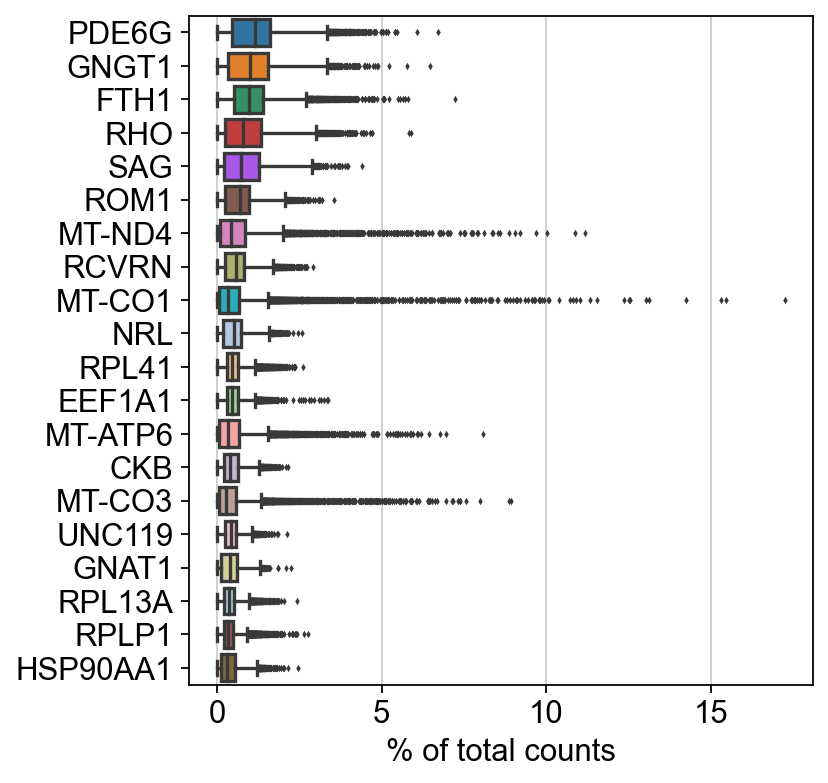

In [62]:
sc.pl.highest_expr_genes(adata, n_top=20)


Basic filtering

In [63]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 20547 × 20848
    obs: 'n_genes'
    var: 'n_cells'

In [64]:
# Calculate metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

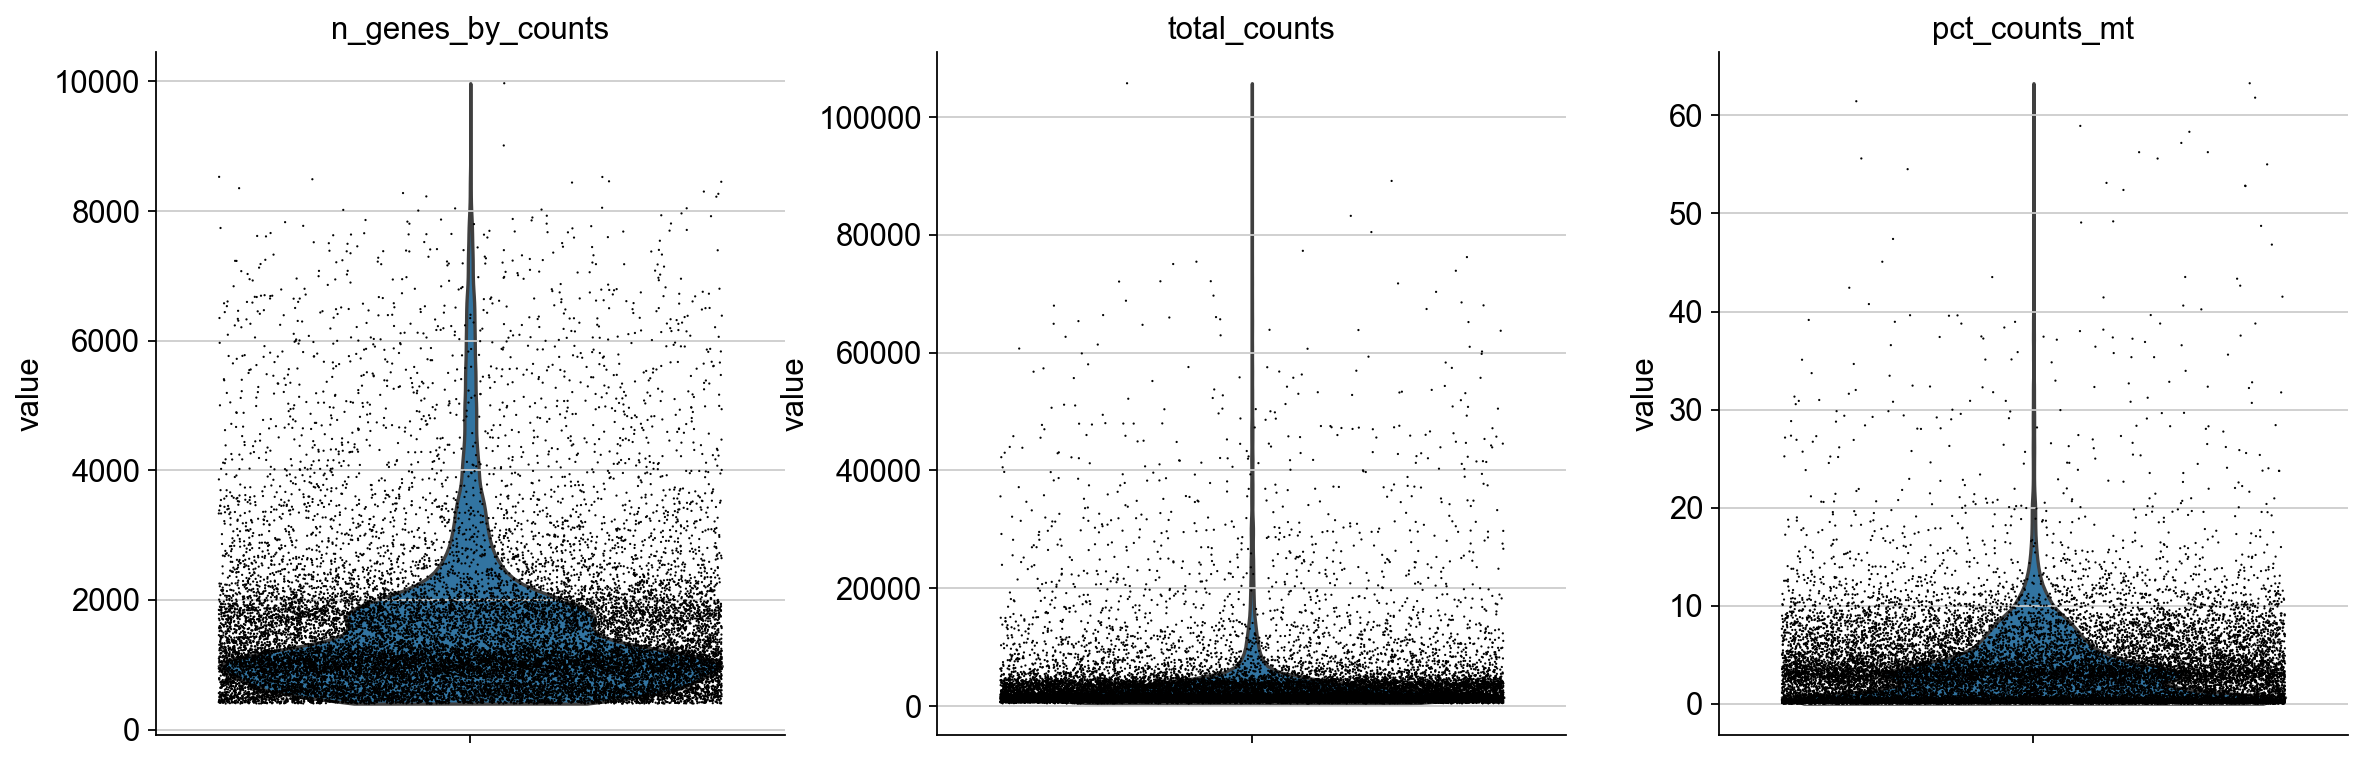

In [65]:
# plot metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [66]:
# calculate median metrics
print("PER CELL:")
print("       median n_genes = ", np.median(np.array(adata.obs.n_genes),axis=0))
print("       median %_mito = ", np.median(np.array(adata.obs['pct_counts_mt']),axis=0))

PER CELL:
       median n_genes =  1143.0
       median %_mito =  2.5586355


Remove cells that have too many mitochondrial genes expressed or too many total counts:

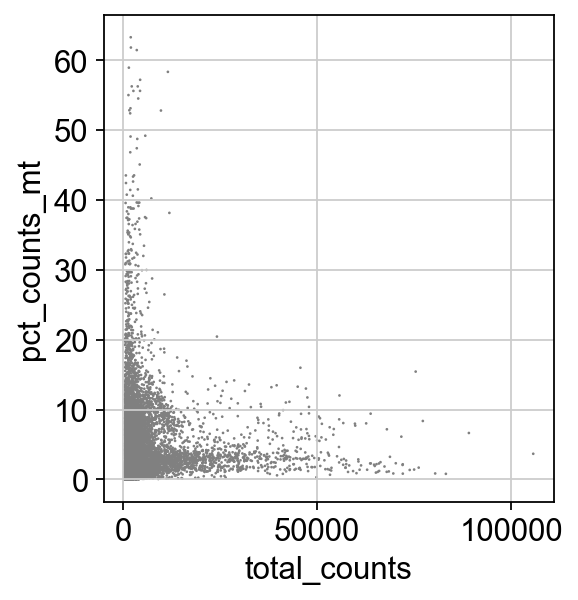

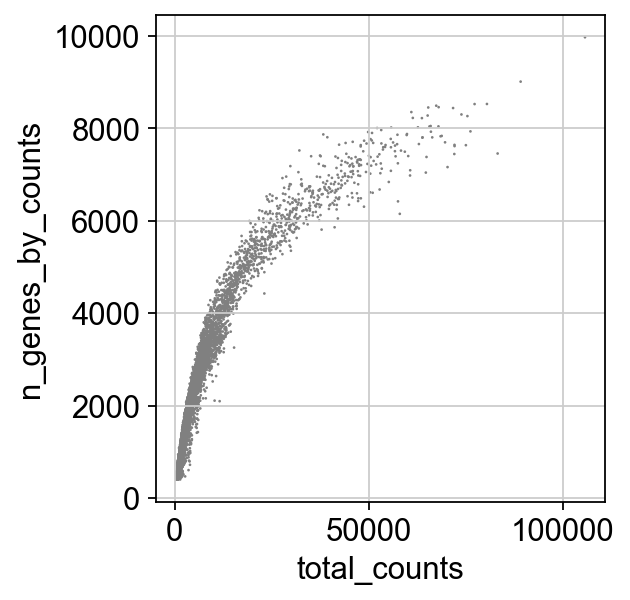

In [67]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [68]:
# Actually do the filtering

adata = adata[adata.obs['n_genes_by_counts'] < 6000, :]
adata = adata[adata.obs['pct_counts_mt'] < 15, :]
adata = adata[adata.obs['total_counts'] < 30000, :]

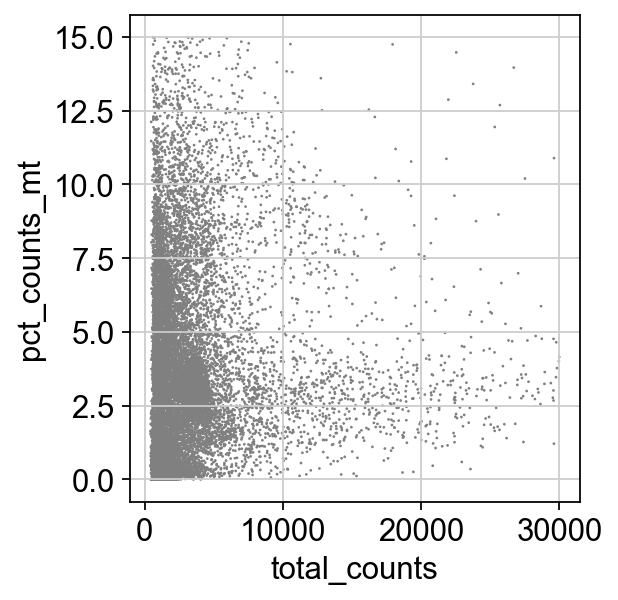

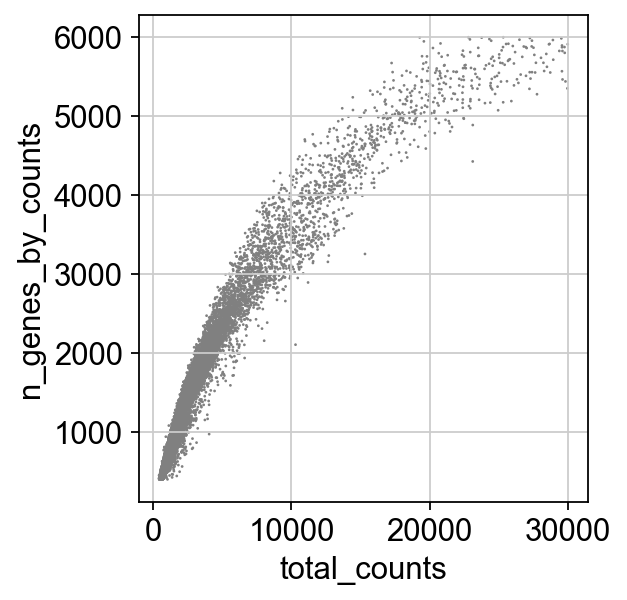

In [69]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

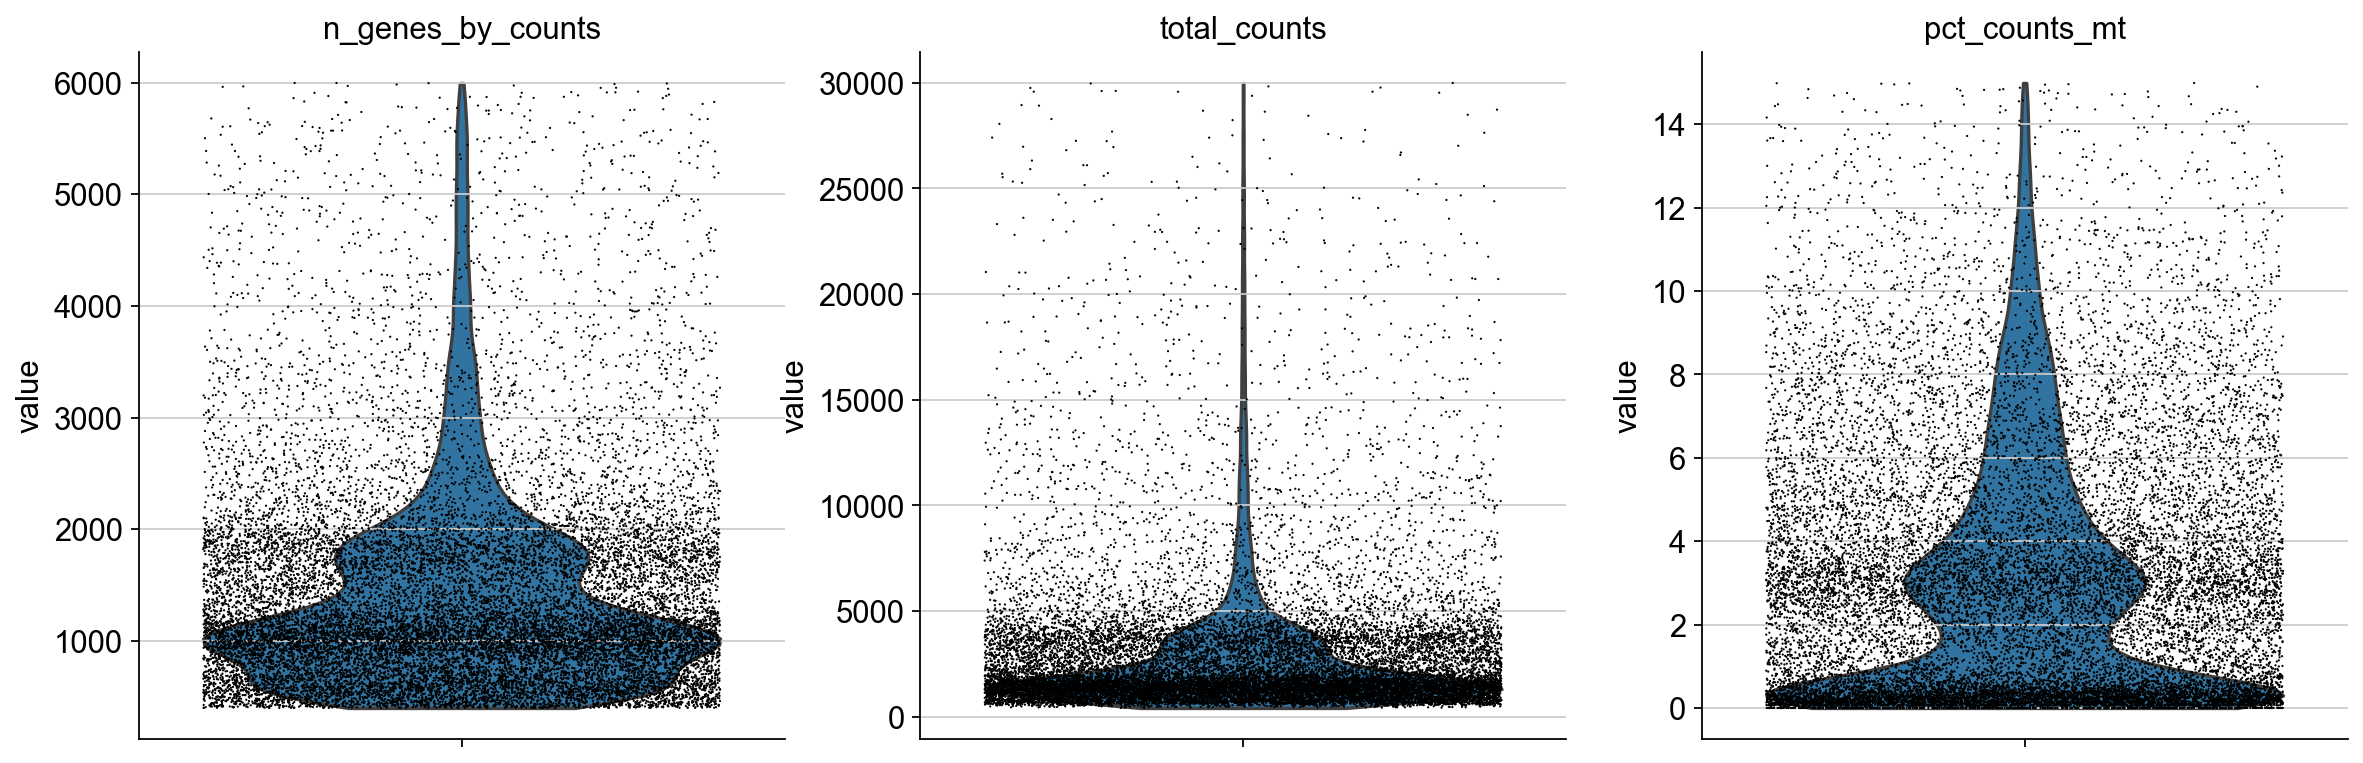

PER CELL:
       median n_genes =  1134.0
       median %_mito =  2.4546423


In [70]:
# Show metrics again after filtering
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

print("PER CELL:")
print("       median n_genes = ", np.median(np.array(adata.obs.n_genes),axis=0))
print("       median %_mito = ", np.median(np.array(adata.obs['pct_counts_mt']),axis=0))

In [71]:
adata

View of AnnData object with n_obs × n_vars = 19789 × 20848
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Process counts

In [72]:

# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell,
#so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data:
sc.pp.log1p(adata)

# Save this counts as raw befor going on
adata.raw = adata

C:\Users\giovanni\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


Identify highly-variable genes.

In [73]:

# with normalize_total
sc.pp.highly_variable_genes(adata,
                            min_mean=0.04,
                            max_mean=3,
                            min_disp=0.5,
                            n_top_genes=1000
                           )

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


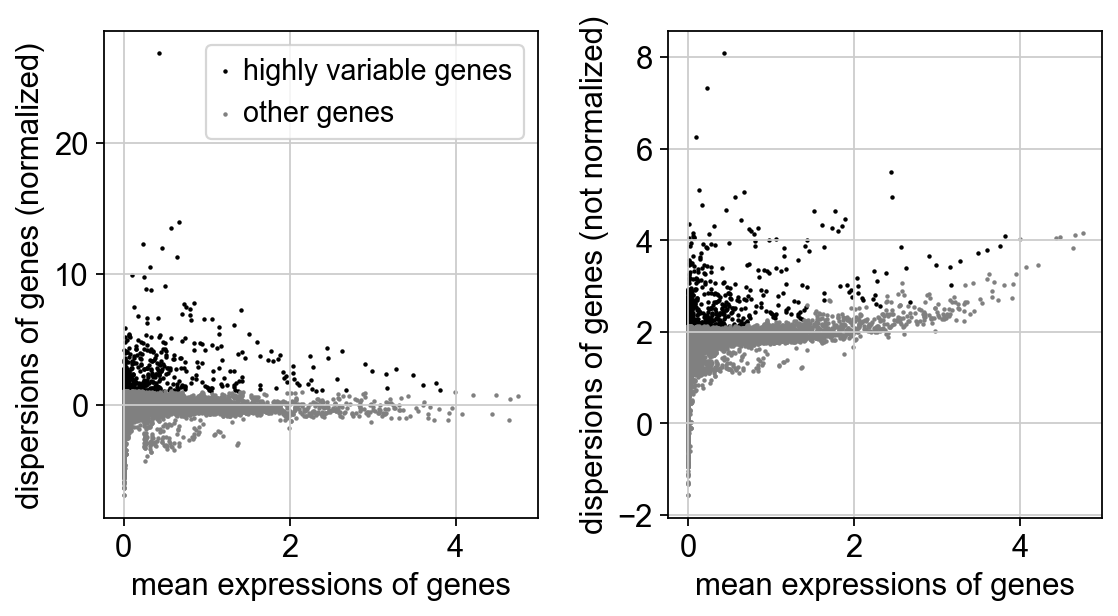

In [74]:
sc.pl.highly_variable_genes(adata)

In [75]:
# count how many HGVs you found
np.sum(adata.var['highly_variable'])

1000

In [76]:
# Actually do the filtering
adata = adata[:, adata.var['highly_variable']]

Save the preprocessed count matrix

In [77]:
adata.write_h5ad('./write/preprocessed_adata.h5ad')

Transform counts [takes a while] **[OPTIONAL]**

In [78]:
# Regress unwanted variations
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale the count values
sc.pp.scale(adata, max_value=10)

# save the transformed counts
adata.write_h5ad('./write/preprocessed_adata_transformed.h5ad')

C:\Users\giovanni\AppData\Roaming\Python\Python39\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
